## Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder



## Načítanie dát

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_4.csv')

## Rozdelenie dát

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

## TextVectorization

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

### Model 1 - LSTM+GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 256)         15360000  
                                                                 
 lstm (LSTM)                 (None, 6000, 256)         525312    
                                                                 
 dropout (Dropout)           (None, 6000, 256)         0         
                                                                 
 gru (GRU)                   (None, 6000, 128)         148224    
                                                             

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
109/109 [==============================] - 64s 517ms/step - loss: 3.1238 - accuracy: 0.0941 - val_loss: 3.0239 - val_accuracy: 0.0928
Epoch 2/10
109/109 [==============================] - 56s 517ms/step - loss: 2.5180 - accuracy: 0.2262 - val_loss: 2.4895 - val_accuracy: 0.2268
Epoch 3/10
109/109 [==============================] - 60s 551ms/step - loss: 1.6965 - accuracy: 0.4501 - val_loss: 2.0255 - val_accuracy: 0.4021
Epoch 4/10
109/109 [==============================] - 53s 484ms/step - loss: 1.2061 - accuracy: 0.6028 - val_loss: 2.3247 - val_accuracy: 0.3505
Epoch 5/10
109/109 [==============================] - 54s 500ms/step - loss: 0.9812 - accuracy: 0.6705 - val_loss: 1.4317 - val_accuracy: 0.5670
Epoch 6/10
109/109 [==============================] - 53s 483ms/step - loss: 0.6275 - accuracy: 0.7899 - val_loss: 3.1847 - val_accuracy: 0.3608
Epoch 7/10
109/109 [==============================] - 56s 510ms/step - loss: 0.7282 - accuracy: 0.7876 - val_loss: 1.0100 - val_ac

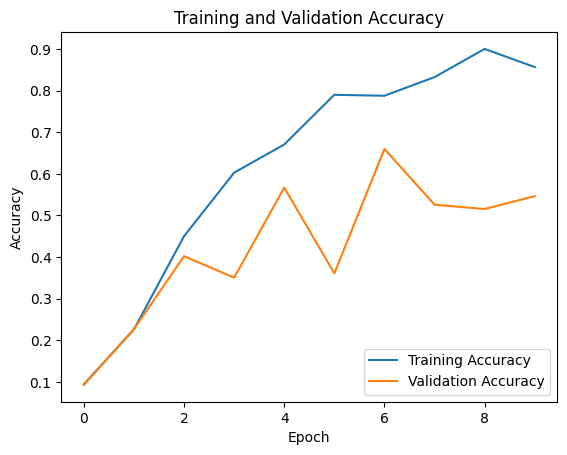

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 234ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.48760330578512395
F1 Score: 0.4770511563187539
Precision: 0.5517588655962331
Recall: 0.48760330578512395


### Model 2 - BIDIRECTIONAL LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 bidirectional (Bidirection  (None, 6000, 256)         394240    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=8)

Epoch 1/10
109/109 [==============================] - 58s 492ms/step - loss: 2.7832 - accuracy: 0.0838 - val_loss: 2.6483 - val_accuracy: 0.1340
Epoch 2/10
109/109 [==============================] - 51s 467ms/step - loss: 2.4860 - accuracy: 0.1481 - val_loss: 2.5052 - val_accuracy: 0.1134
Epoch 3/10
109/109 [==============================] - 51s 471ms/step - loss: 2.1538 - accuracy: 0.2239 - val_loss: 2.0977 - val_accuracy: 0.1856
Epoch 4/10
109/109 [==============================] - 51s 466ms/step - loss: 1.8322 - accuracy: 0.3042 - val_loss: 2.1685 - val_accuracy: 0.2062
Epoch 5/10
109/109 [==============================] - 52s 473ms/step - loss: 1.4950 - accuracy: 0.4271 - val_loss: 1.6372 - val_accuracy: 0.2887
Epoch 6/10
109/109 [==============================] - 51s 469ms/step - loss: 1.2427 - accuracy: 0.5350 - val_loss: 1.4595 - val_accuracy: 0.4021
Epoch 7/10
109/109 [==============================] - 50s 459ms/step - loss: 0.9242 - accuracy: 0.6361 - val_loss: 1.5411 - val_ac

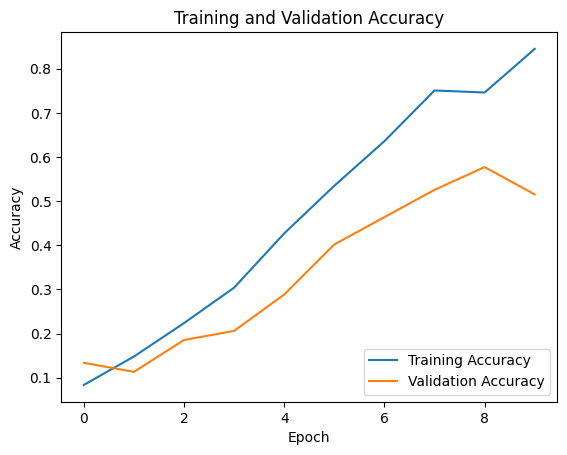

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 2s 189ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6363636363636364
F1 Score: 0.6360460025434038
Precision: 0.7212396463878679
Recall: 0.6363636363636364


### Model 3 - LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(128, return_sequences=True)(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(64)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 lstm_2 (LSTM)               (None, 6000, 128)         197120    
                                                                 
 dropout_5 (Dropout)         (None, 6000, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=8)

Epoch 1/10
109/109 [==============================] - 52s 434ms/step - loss: 2.9231 - accuracy: 0.0838 - val_loss: 2.8691 - val_accuracy: 0.1134
Epoch 2/10
109/109 [==============================] - 48s 441ms/step - loss: 2.7682 - accuracy: 0.0896 - val_loss: 2.8863 - val_accuracy: 0.1134
Epoch 3/10
109/109 [==============================] - 46s 423ms/step - loss: 2.4881 - accuracy: 0.1929 - val_loss: 2.7924 - val_accuracy: 0.1134
Epoch 4/10
109/109 [==============================] - 46s 425ms/step - loss: 2.0882 - accuracy: 0.3249 - val_loss: 2.9939 - val_accuracy: 0.0825
Epoch 5/10
109/109 [==============================] - 46s 418ms/step - loss: 1.7475 - accuracy: 0.4455 - val_loss: 3.1275 - val_accuracy: 0.0928
Epoch 6/10
109/109 [==============================] - 46s 420ms/step - loss: 1.5786 - accuracy: 0.5052 - val_loss: 3.6158 - val_accuracy: 0.1031


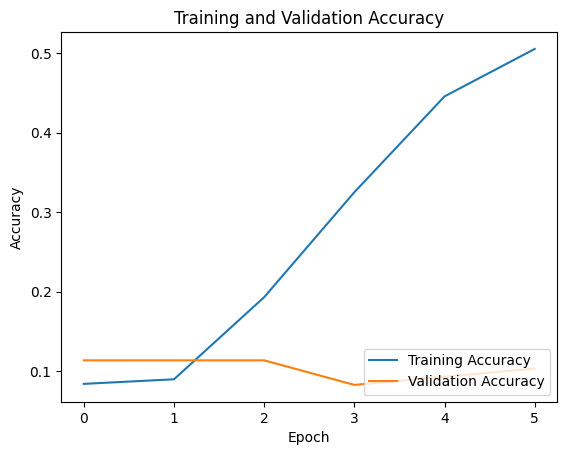

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 240ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.10743801652892562
F1 Score: 0.07558798915037773
Precision: 0.08824013452112625
Recall: 0.10743801652892562
